In [145]:
import torch
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.benchmark = False

g = torch.Generator()
g.manual_seed(SEED)

# Plots

In [169]:
def plot_real_vs_predicted(trues, preds):
    trues_flat = trues.flatten()
    preds_flat = preds.flatten()
    errors = preds_flat - trues_flat
    
    plt.figure(figsize=(7,7))
    plt.scatter(trues_flat, preds_flat, c=np.abs(errors), cmap='viridis', alpha=0.7)
    plt.plot([trues.min(), trues.max()],
             [trues.min(), trues.max()],
             'r--', label='Perfect prediction')
    plt.colorbar(label="Absolute Error")
    plt.xlabel("Età reale")
    plt.ylabel("Età predetta")
    plt.title("Predicted vs True Age (colored by error)")
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_losses_zoom(train_losses, val_losses):
    x = np.arange(10, len(train_losses))
    plt.figure(figsize=(8,5))
    plt.plot(x, train_losses[10:], label="Train Loss")
    plt.plot(x, val_losses[10:], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.title("Training and Validation Loss over Epochs")
    plt.legend()
    plt.grid(True)    
    plt.show()
    
def plot_losses_from_gridSearch(df_history):
    plt.figure(figsize=(8,5))
    plt.plot(df_history['epoch'][10:], df_history['train_loss'][10:], label='Train Loss')
    plt.plot(df_history['epoch'][10:], df_history['valid_loss'][10:], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Datasets

In [148]:
DATA_PATH = '../datasets/preprocessed/final_merged_clinical_miRNA.csv'
df = pd.read_csv(DATA_PATH)

# Converti la colonna di stringhe in liste di float
def parse_array(x):
    if isinstance(x, str):
        x = x.strip("[]")
        return np.array([float(i) for i in x.split(",")])
    return np.array(x)

df["reads_per_million_miRNA_mapped"] = df["reads_per_million_miRNA_mapped"].apply(parse_array)
X = np.vstack(df["reads_per_million_miRNA_mapped"].values)
y = df["age_at_initial_pathologic_diagnosis"].values

# Stratifica per quantili di età per avere distribuzioni simili nei set
y_bins = pd.qcut(y, q=10, labels=False, duplicates="drop")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y_bins)

class MiRNADataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)  # Porta a vettore colonna

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
class MiRNANet(nn.Module):
    def __init__(self, input_dim, hidden1=512, hidden2=256, dropout=0.1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, 1)
        )

    def forward(self, x):
        return self.model(x)

In [76]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((606, 1881), (606,), (152, 1881), (152,))

In [69]:
import numpy as np
print("y_train mean/std:", np.mean(y_train), np.std(y_train))
print("y_test mean/std:", np.mean(y_test), np.std(y_test))


y_train mean/std: 57.94884488448845 13.36202034778495
y_test mean/std: 57.6578947368421 12.40336608766786


# senza scaled

In [94]:
train_ds = MiRNADataset(X_train, y_train)
test_ds = MiRNADataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, generator=g)
test_loader = DataLoader(test_ds, batch_size=32)

input_dim = X_train.shape[1]
model = MiRNANet(input_dim)

# Training setup
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-6)

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',        # riduce LR quando la metrica (loss) smette di diminuire
    factor=0.5,        # dimezza il learning rate
    patience=10        # aspetta 10 epoche senza miglioramenti
)

train_losses = []
val_losses = []

# Training loop
for epoch in range(150):
    model.train()
    total_train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)

    # ---- VALIDATION ----
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(test_loader)

    scheduler.step(avg_val_loss)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1:03d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

Epoch 001 | Train Loss: 7572172.2549 | Val Loss: 23168.8637
Epoch 002 | Train Loss: 16520.8844 | Val Loss: 1959.5163
Epoch 003 | Train Loss: 5941.8618 | Val Loss: 768.7253
Epoch 004 | Train Loss: 4064.8166 | Val Loss: 408.1468
Epoch 005 | Train Loss: 2568.2458 | Val Loss: 1566.8152
Epoch 006 | Train Loss: 1912.2166 | Val Loss: 260.0522
Epoch 007 | Train Loss: 1019.9635 | Val Loss: 559.8088
Epoch 008 | Train Loss: 706.6882 | Val Loss: 229.9582
Epoch 009 | Train Loss: 424.1303 | Val Loss: 304.7444
Epoch 010 | Train Loss: 398.1524 | Val Loss: 345.6237
Epoch 011 | Train Loss: 446.7227 | Val Loss: 362.5067
Epoch 012 | Train Loss: 293.3421 | Val Loss: 256.9762
Epoch 013 | Train Loss: 272.5640 | Val Loss: 320.8446
Epoch 014 | Train Loss: 302.5945 | Val Loss: 198.2312
Epoch 015 | Train Loss: 325.8340 | Val Loss: 227.7635
Epoch 016 | Train Loss: 244.1134 | Val Loss: 238.2354
Epoch 017 | Train Loss: 303.6063 | Val Loss: 211.5222
Epoch 018 | Train Loss: 207.9192 | Val Loss: 213.0738
Epoch 019 | T

In [95]:
model.eval()  # modalità evaluation
preds = []
trues = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        preds.append(outputs.numpy())
        trues.append(y_batch.numpy())

# Concatenazione dei batch
preds = np.vstack(preds).ravel()  # array 1D
trues = np.vstack(trues).ravel()  # array 1D

mae = mean_absolute_error(trues, preds)
r2 = r2_score(trues, preds)
print(f"Test MAE: {mae:.2f}")
print(f"Test R²: {r2:.3f}")

Test MAE: 11.46
Test R²: -0.147


In [93]:
model.eval()
preds_train, preds_test = [], []
with torch.no_grad():
    for Xb, _ in train_loader:
        preds_train.append(model(Xb).numpy())
    for Xb, _ in test_loader:
        preds_test.append(model(Xb).numpy())

preds_train = np.vstack(preds_train)
preds_test = np.vstack(preds_test)

# RMSE in anni
rmse_train = mean_absolute_error(y_train, preds_train)
rmse_test = mean_absolute_error(y_test, preds_test)

print("\n==============================")
print(f"RMSE train (anni): {rmse_train:.2f}")
print(f"RMSE test  (anni): {rmse_test:.2f}")
print("==============================\n")


RMSE train (anni): 11.45
RMSE test  (anni): 12.06


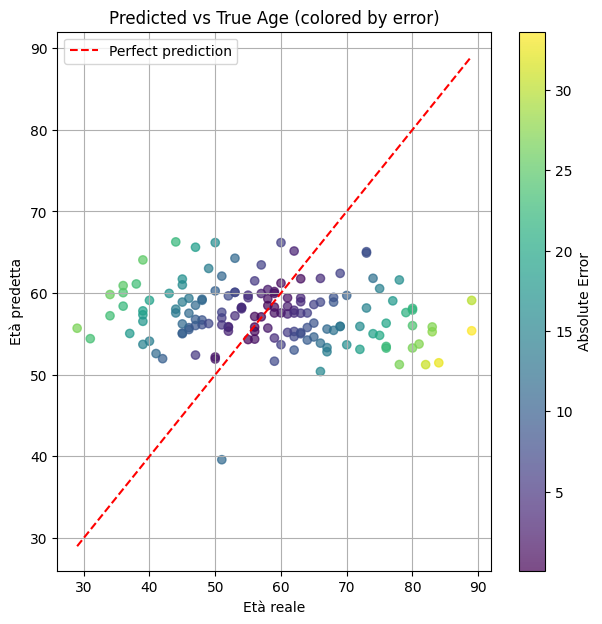

In [96]:
plot_real_vs_predicted(trues, preds)

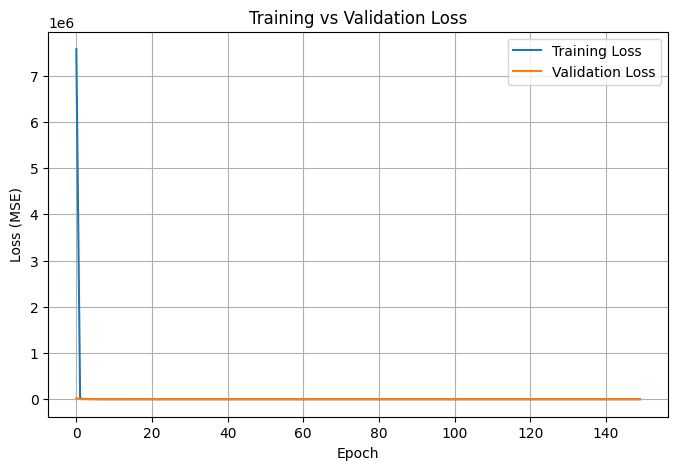

In [97]:
plot_losses(train_losses, val_losses)

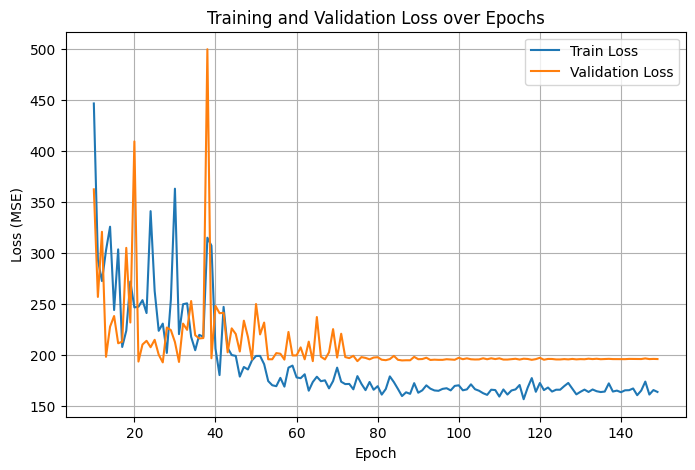

In [98]:
plot_losses_zoom(train_losses, val_losses)

# con scaled

In [163]:
############
# Scaler X #
############

scaler = "type_3"

if scaler == "type_1":
    # Scaler: caso 1
    X_train_log = np.log10(X_train + 1)
    X_test_log = np.log10(X_test + 1)
                              
    scaler_X = StandardScaler().fit(X_train_log)
    X_train_scaled = scaler_X.transform(X_train_log)
    X_test_scaled = scaler_X.transform(X_test_log)

elif scaler == "type_2":
    # Scaler: caso 2
    scaler_X = RobustScaler().fit(X_train)
    X_train_scaled = scaler_X.transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

elif scaler == "type_3":
    # Scaler: caso 3
    scaler_X = QuantileTransformer(output_distribution='normal', random_state=SEED).fit(X_train)
    X_train_scaled = scaler_X.transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

############
# Scaler y #
############

"""scaler_y = StandardScaler().fit(y_train.reshape(-1,1))
y_train_scaled = scaler_y.transform(y_train.reshape(-1,1)).ravel()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).ravel()

from sklearn.decomposition import PCA
pca = PCA(n_components=500, random_state=SEED).fit(X_train_scaled)
X_train_scaled = pca.transform(X_train_scaled)
X_test_scaled = pca.transform(X_test_scaled)

train_ds = MiRNADataset(X_train_scaled, y_train_scaled)
test_ds = MiRNADataset(X_test_scaled, y_test_scaled)"""

train_ds = MiRNADataset(X_train, y_train)
test_ds = MiRNADataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, generator=g)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

input_dim = X_train.shape[1]
model = MiRNANet(input_dim,256, 128, 0.2)

# Training setup
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',        # riduce LR quando la metrica (loss) smette di diminuire
    factor=0.5,        # dimezza il learning rate
    patience=10        # aspetta 10 epoche senza miglioramenti
)

train_losses = []
val_losses = []

# Training loop
for epoch in range(150):
    model.train()
    total_train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)

    # ---- VALIDATION ----
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(test_loader)

    scheduler.step(avg_val_loss)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1:03d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

c:\users\giorg\appdata\local\programs\python\python39\lib\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (606). n_quantiles is set to n_samples.
  warnings.warn(


Epoch 001 | Train Loss: 346273.4624 | Val Loss: 24172.1984
Epoch 002 | Train Loss: 19863.1861 | Val Loss: 2240.7853
Epoch 003 | Train Loss: 11494.4898 | Val Loss: 1992.9054
Epoch 004 | Train Loss: 8434.3552 | Val Loss: 1735.9808
Epoch 005 | Train Loss: 5997.0441 | Val Loss: 1525.4371
Epoch 006 | Train Loss: 5132.5610 | Val Loss: 2002.4734
Epoch 007 | Train Loss: 4279.6212 | Val Loss: 1073.3913
Epoch 008 | Train Loss: 3910.5210 | Val Loss: 855.6904
Epoch 009 | Train Loss: 3394.4951 | Val Loss: 620.6054
Epoch 010 | Train Loss: 3652.7446 | Val Loss: 1233.8228
Epoch 011 | Train Loss: 2850.5460 | Val Loss: 995.2346
Epoch 012 | Train Loss: 2674.9908 | Val Loss: 542.0376
Epoch 013 | Train Loss: 2170.9529 | Val Loss: 811.8119
Epoch 014 | Train Loss: 2261.9959 | Val Loss: 680.6788
Epoch 015 | Train Loss: 1662.6627 | Val Loss: 610.4039
Epoch 016 | Train Loss: 1586.8840 | Val Loss: 440.6146
Epoch 017 | Train Loss: 1847.2810 | Val Loss: 425.3405
Epoch 018 | Train Loss: 1255.4466 | Val Loss: 520.65

In [161]:
# Valutazione
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)        
        all_preds.append(outputs.numpy())
        all_targets.append(y_batch.numpy())
        
preds_scaled = np.vstack(all_preds)
y_scaled = np.vstack(all_targets)

#preds_real = scaler_y.inverse_transform(preds_scaled)
#y_real = scaler_y.inverse_transform(y_scaled)
y_real, preds_real = y_scaled, preds_scaled

from sklearn.metrics import mean_absolute_error, r2_score

mae = mean_absolute_error(y_real, preds_real)
r2 = r2_score(y_real, preds_real)

print(f"Test MAE (anni): {mae:.2f}")
print(f"R²: {r2:.3f}")

Test MAE (anni): 12.21
R²: -0.350


I risultati non sono sempre gli stessi =(

log + standard Scaler
    Test MAE (anni): 13.47
    R²: -0.692

RobustScaler
    Test MAE (anni): 11.10
    R²: -0.231

QuantileTransformer
    Test MAE (anni): 11.22
    R²: -0.248

In [164]:
model.eval()
preds_train, preds_test = [], []
with torch.no_grad():
    for Xb, _ in train_loader:
        preds_train.append(model(Xb).numpy())
    for Xb, _ in test_loader:
        preds_test.append(model(Xb).numpy())

preds_train = np.vstack(preds_train)
preds_test = np.vstack(preds_test)

# RMSE in anni
rmse_train = mean_absolute_error(y_train, preds_train)
rmse_test = mean_absolute_error(y_test, preds_test)

print("\n==============================")
print(f"RMSE train (anni): {rmse_train:.2f}")
print(f"RMSE test  (anni): {rmse_test:.2f}")
print("==============================\n")


RMSE train (anni): 11.67
RMSE test  (anni): 12.65


In [104]:
preds_real

array([[ 69.872574],
       [ 53.917957],
       [ 65.20615 ],
       [ 68.256004],
       [ 62.074337],
       [ 61.76163 ],
       [ 54.244884],
       [ 63.53654 ],
       [ 47.885357],
       [ 72.75774 ],
       [ 61.32532 ],
       [ 50.41816 ],
       [ 63.55592 ],
       [ 60.489655],
       [ 47.845367],
       [ 50.60966 ],
       [ 55.245476],
       [ 50.91368 ],
       [ 54.09758 ],
       [ 50.264038],
       [ 62.43946 ],
       [ 51.459118],
       [ 82.80096 ],
       [ 49.924416],
       [ 62.19993 ],
       [ 61.931496],
       [ 46.69118 ],
       [ 64.898865],
       [ 62.08084 ],
       [ 64.96658 ],
       [ 54.28155 ],
       [ 48.017807],
       [ 50.135582],
       [ 54.807537],
       [ 58.43454 ],
       [ 69.121254],
       [ 57.056484],
       [ 71.47349 ],
       [ 42.749825],
       [ 51.874775],
       [ 54.382652],
       [ 55.03462 ],
       [ 56.285587],
       [ 60.05907 ],
       [ 53.16592 ],
       [ 60.51118 ],
       [ 60.171284],
       [ 51.1

In [40]:
y_real

array([[51.      ],
       [45.      ],
       [59.      ],
       [50.      ],
       [54.      ],
       [51.      ],
       [67.      ],
       [48.      ],
       [42.      ],
       [70.      ],
       [55.      ],
       [34.      ],
       [66.      ],
       [67.      ],
       [58.      ],
       [68.      ],
       [66.      ],
       [64.      ],
       [42.      ],
       [59.      ],
       [69.      ],
       [49.      ],
       [50.      ],
       [69.      ],
       [68.      ],
       [57.      ],
       [63.      ],
       [64.      ],
       [62.      ],
       [57.      ],
       [39.      ],
       [47.      ],
       [83.      ],
       [72.      ],
       [39.      ],
       [74.      ],
       [36.      ],
       [61.      ],
       [62.      ],
       [56.      ],
       [67.      ],
       [49.      ],
       [81.      ],
       [34.      ],
       [50.      ],
       [25.999998],
       [56.      ],
       [66.      ],
       [64.      ],
       [72.      ],


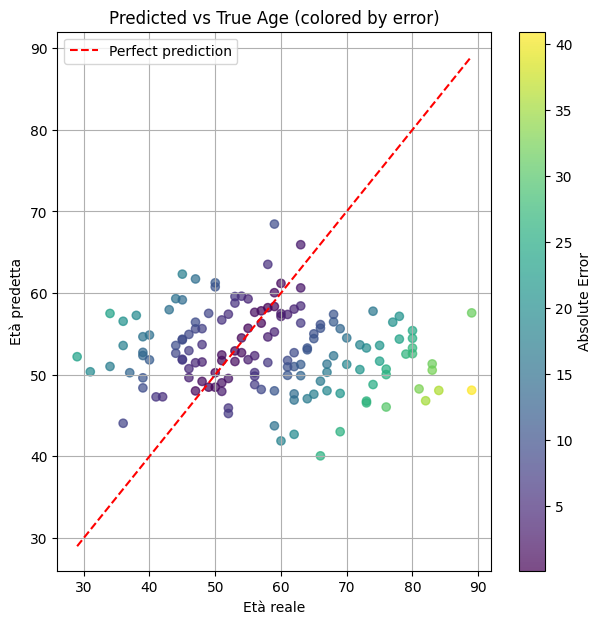

In [165]:
plot_real_vs_predicted(y_real, preds_real)

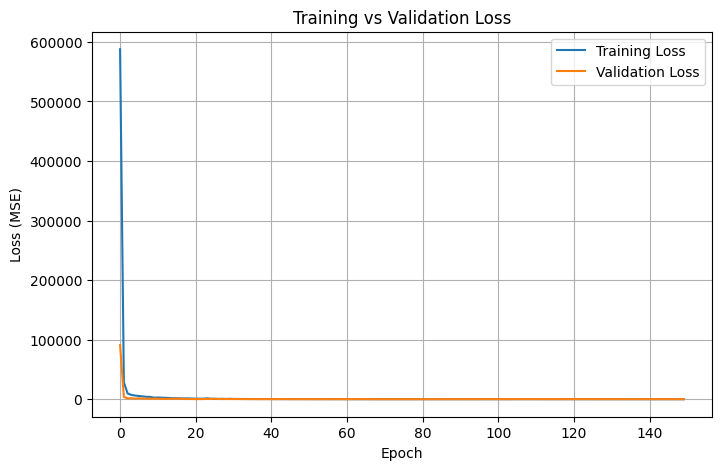

In [136]:
plot_losses(train_losses, val_losses)

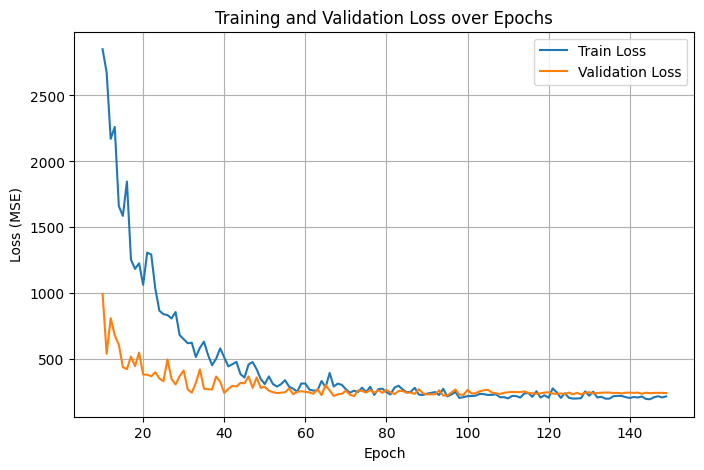

In [166]:
plot_losses_zoom(train_losses, val_losses)

In [63]:
trues_flat = y_real.flatten()
preds_flat = preds_real.flatten()
errors = preds_flat - trues_flat

In [64]:
len(trues_flat)

152

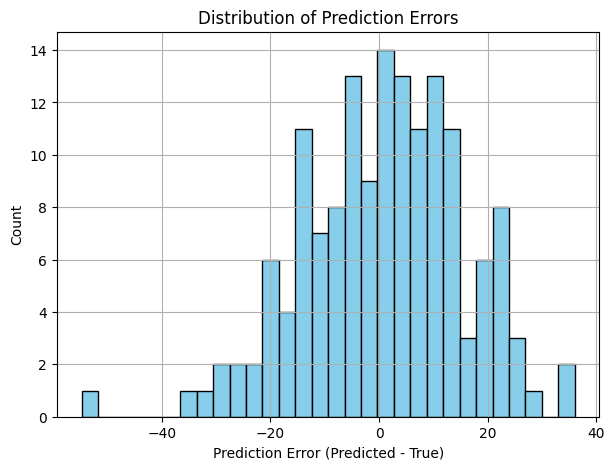

In [167]:
plt.figure(figsize=(7,5))
plt.hist(errors, bins=30, color='skyblue', edgecolor='k')
plt.xlabel("Prediction Error (Predicted - True)")
plt.ylabel("Count")
plt.title("Distribution of Prediction Errors")
plt.grid(True)
plt.show()

# GridSearch - senza scaled

In [171]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from skorch.callbacks import LRScheduler
import random

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DATA_PATH = '../datasets/preprocessed/final_merged_clinical_miRNA.csv'
df = pd.read_csv(DATA_PATH)

# Converti la colonna di stringhe in liste di float
def parse_array(x):
    if isinstance(x, str):
        x = x.strip("[]")
        return np.array([float(i) for i in x.split(",")])
    return np.array(x)

df["reads_per_million_miRNA_mapped"] = df["reads_per_million_miRNA_mapped"].apply(parse_array)
X = np.vstack(df["reads_per_million_miRNA_mapped"].values)
y = df["age_at_initial_pathologic_diagnosis"].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# X_train, X_test già ok come numpy array
X_train_sk = X_train.astype(np.float32)
X_test_sk = X_test.astype(np.float32)

# y deve essere 1D
y_train_sk = y_train.astype(np.float32).ravel()
y_test_sk = y_test.astype(np.float32).ravel()

  
class MiRNANet(nn.Module):
    def __init__(self, input_dim=1000, hidden1=256, hidden2=128, dropout=0.3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, 1)
        )

    def forward(self, x):
        return self.model(x).view(-1)

# GRID SEARCH
net = NeuralNetRegressor(
    module=MiRNANet,
    module__input_dim=X_train_sk.shape[1],
    max_epochs=150,
    lr=1e-3,
    batch_size=32,
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=1e-5,
    criterion=nn.MSELoss,
    callbacks=[
         ('lr_scheduler', LRScheduler(
             ReduceLROnPlateau, 
             mode='min', 
             factor=0.7, 
             patience=15, 
             monitor='valid_loss',
             min_lr=1e-6
         ))
    ],
)

params = {
    #'module__hidden1': [128, 256],
    #'module__hidden2': [64, 128],
    #'module__dropout': [0.2, 0.3],
    #'optimizer__weight_decay': [0, 1e-5, 1e-4],
    #'callbacks__lr_scheduler__factor': [0.8, 0.6],
    #'callbacks__lr_scheduler__patience': [15, 10],
    'lr': [1e-3, 5e-4]
}

gs = GridSearchCV(net, 
                  params, 
                  refit=True, 
                  cv=3,  # cross-validation folds 
                  scoring='neg_mean_squared_error', 
                  verbose=1)
gs.fit(X_train_sk, y_train_sk.ravel())

best_model = gs.best_estimator_
print("Best hyperparameters:", gs.best_params_)

preds = best_model.predict(X_test_sk)
mae = mean_absolute_error(y_test_sk, preds)
r2 = r2_score(y_test_sk, preds)
print(f"Test MAE: {mae:.2f} | R2: {r2:.2f}")

Fitting 3 folds for each of 2 candidates, totalling 6 fits
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1  1284903.6865   375903.4653  0.0010  0.0833
      2   168118.3091    35109.2284  0.0010  0.0666
      3    57191.2486     8080.0294  0.0010  0.0739
      4    28156.3477     7020.6462  0.0010  0.0707
      5    16192.0474     4887.4244  0.0010  0.0737
      6    12155.5796     3352.9041  0.0010  0.0729
      7    10147.0292     2770.5792  0.0010  0.0690
      8     8111.9545     2187.3082  0.0010  0.0682
      9     6722.5285     3797.5202  0.0010  0.0756
     10     7756.1543     2712.7487  0.0010  0.0714
     11     6194.4937     3268.5632  0.0010  0.0682
     12     5759.3148     2641.1624  0.0010  0.0708
     13     5502.1133     2129.6611  0.0010  0.0669
     14     4514.4014     2513.0754  0.0010  0.0697
     15     5125.2576     2424.5751  0.0010  0.0660
     16     4174.5649     4440.8880  0.0010  0.0688
     

Best hyperparameters: {'lr': 0.001, 'module__hidden1': 256, 'module__hidden2': 64}
Test MAE: 11.00

In [65]:
############
# TOP MODELS
############
results = pd.DataFrame(gs.cv_results_)

# Ordina in base al punteggio (più alto = migliore, perché neg_mean_squared_error)
results_sorted = results.sort_values(by='mean_test_score', ascending=False)

# Prendi top 5
top5 = results_sorted.head(5)

# Stampa i parametri e il punteggio
for i, row in top5.iterrows():
    print(f"Rank {i+1}: mean_test_score = {row['mean_test_score']:.4f}, params = {row['params']}")

Rank 2: mean_test_score = -464.7534, params = {'lr': 0.0005}
Rank 1: mean_test_score = -487.3991, params = {'lr': 0.001}


In [66]:
history = best_model.history
history[0].keys()

dict_keys(['batches', 'epoch', 'train_batch_count', 'valid_batch_count', 'dur', 'train_loss', 'train_loss_best', 'valid_loss', 'valid_loss_best', 'event_lr'])

In [67]:
import pandas as pd
pd.DataFrame(history)

,batches,epoch,train_batch_count,valid_batch_count,dur,train_loss,train_loss_best,valid_loss,valid_loss_best,event_lr
0,"[{'train_loss': 2300441.75, 'train_batch_size'...",1,16,4,0.133009,472207.474819,True,120196.473233,True,0.000500
1,"[{'train_loss': 198389.40625, 'train_batch_siz...",2,16,4,0.147647,82147.807690,True,17332.283171,True,0.000500
2,"[{'train_loss': 44845.06640625, 'train_batch_s...",3,16,4,0.138000,37059.365702,True,7299.950924,True,0.000500
3,"[{'train_loss': 25713.865234375, 'train_batch_...",4,16,4,0.124435,33363.901920,True,6507.723080,True,0.000500
4,"[{'train_loss': 38428.99609375, 'train_batch_s...",5,16,4,0.139437,26579.354985,True,7743.432697,False,0.000500
...,...,...,...,...,...,...,...,...,...,...
145,"[{'train_loss': 421.7119140625, 'train_batch_s...",146,16,4,0.470354,303.176536,False,584.514034,False,0.000120
146,"[{'train_loss': 459.20660400390625, 'train_bat...",147,16,4,0.477565,332.812608,False,510.725435,False,0.000120
147,"[{'train_loss': 309.56610107421875, 'train_bat...",148,16,4,0.482327,303.406347,False,458.433256,False,0.000084
148,"[{'train_loss': 590.858642578125, 'train_batch...",149,16,4,0.473643,348.905159,False,390.128161,False,0.000084


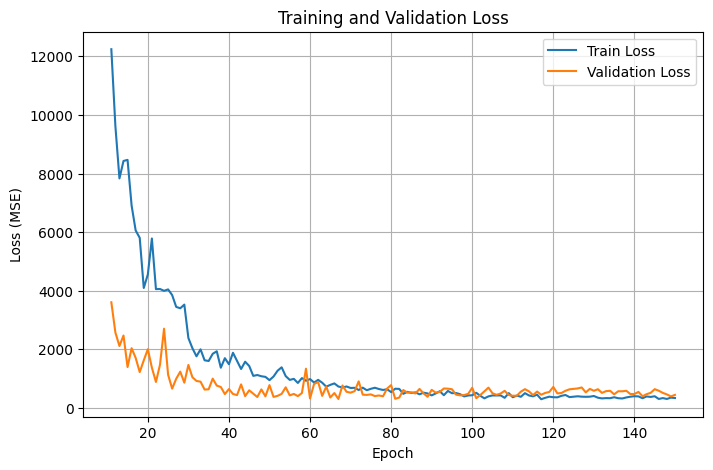

In [68]:
df_history = pd.DataFrame(best_model.history)
plot_losses_from_gridSearch(df_history)

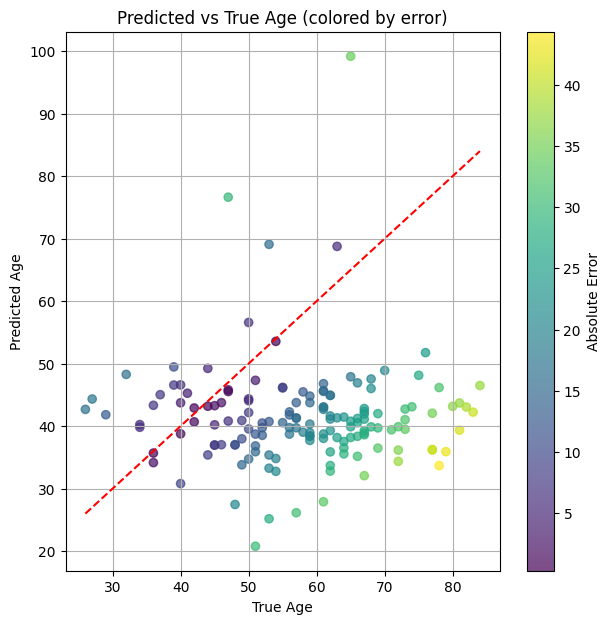

In [70]:
plot_real_vs_predicted(y_test_sk, preds)

# GridSearch - con scaler

In [303]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DATA_PATH = '../datasets/preprocessed/final_merged_clinical_miRNA.csv'
df = pd.read_csv(DATA_PATH)

# Converti la colonna di stringhe in liste di float
def parse_array(x):
    if isinstance(x, str):
        x = x.strip("[]")
        return np.array([float(i) for i in x.split(",")])
    return np.array(x)

df["reads_per_million_miRNA_mapped"] = df["reads_per_million_miRNA_mapped"].apply(parse_array)
X = np.vstack(df["reads_per_million_miRNA_mapped"].values)
y = df["age_at_initial_pathologic_diagnosis"].values

y_bins = pd.qcut(y, q=10, labels=False, duplicates="drop")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y_bins)

scaler = "type_1"

if scaler == "type_1":
    # Scaler: caso 1
    X_train_log = np.log10(X_train + 1)
    X_test_log = np.log10(X_test + 1)
                              
    scaler_X = StandardScaler().fit(X_train_log)
    X_train_scaled = scaler_X.transform(X_train_log)
    X_test_scaled = scaler_X.transform(X_test_log)

elif scaler == "type_2":
    # Scaler: caso 2
    scaler_X = RobustScaler().fit(X_train)
    X_train_scaled = scaler_X.transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

elif scaler == "type_3":
    # Scaler: caso 3
    scaler_X = QuantileTransformer(output_distribution='normal', random_state=SEED).fit(X_train)
    X_train_scaled = scaler_X.transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler().fit(y_train.reshape(-1,1))
y_train_scaled = scaler_y.transform(y_train.reshape(-1,1)).ravel()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).ravel()

"""y_train_scaled = y_train
y_test_scaled = y_test"""

#pip install umap-learn
"""import umap
n_features_umap = 400
reducer = umap.UMAP(n_neighbors=25, 
                    min_dist=0.1, 
                    n_components=n_features_umap,
                    random_state=SEED, 
                    metric='euclidean')
X_train_scaled = reducer.fit_transform(X_train_scaled)
X_test_scaled = reducer.transform(X_test_scaled)"""

# X_train, X_test già ok come numpy array
X_train_sk = X_train_scaled.astype(np.float32)
X_test_sk = X_test_scaled.astype(np.float32)


# y deve essere 1D
y_train_sk = y_train_scaled.astype(np.float32).ravel()
y_test_sk = y_test_scaled.astype(np.float32).ravel()

"""from sklearn.decomposition import PCA
pca = PCA(n_components=200, random_state=SEED).fit(X_train_sk)
X_train_sk = pca.transform(X_train_sk)
X_test_sk = pca.transform(X_test_sk)"""


class MiRNANet(nn.Module):
    def __init__(self, input_dim, hidden1=512, hidden2=256, dropout=0.1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, 1)
        )

    def forward(self, x):
        return self.model(x).view(-1)

# GRID SEARCH
net = NeuralNetRegressor(
    module=MiRNANet,
    module__input_dim=X_train_sk.shape[1],
    max_epochs=150,
    lr=1e-3,
    batch_size=32,
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=1e-5,
    criterion=nn.MSELoss,
    callbacks=[
         ('lr_scheduler', LRScheduler(
             ReduceLROnPlateau, 
             mode='min', 
             factor=0.8, 
             patience=20, 
             monitor='valid_loss',
             min_lr=1e-5
         ))
    ],
)

params = {
    #'module__hidden1': [128, 256, 512],
    #'module__hidden2': [64, 128, 256],
    #'module__dropout': [0.2, 0.3],
    #'optimizer__weight_decay': [0, 1e-5, 1e-4],
    #'callbacks__lr_scheduler__factor': [0.8, 0.6],
    #'callbacks__lr_scheduler__patience': [15, 10],
    'lr':[1e-3, 5e-4]
}

gs = GridSearchCV(net, 
                  params, 
                  refit=True, 
                  cv=2,# 3,  # cross-validation folds 
                  scoring='neg_mean_squared_error', 
                  verbose=1)
gs.fit(X_train_sk, y_train_sk.ravel())

best_model = gs.best_estimator_
print("Best hyperparameters:", gs.best_params_)

preds = best_model.predict(X_test_sk)
mae = mean_absolute_error(y_test_sk, preds)
r2 = r2_score(y_test_sk, preds)
print(f"Test MAE: {mae:.2f} | R2: {r2:.2f}")

Fitting 2 folds for each of 2 candidates, totalling 4 fits
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1        1.2629        0.9956  0.0010  0.0908
      2        0.5139        1.0470  0.0010  0.0982
      3        0.2617        1.0452  0.0010  0.0943
      4        0.2262        1.0210  0.0010  0.0910
      5        0.1331        1.0490  0.0010  0.0930
      6        0.0823        1.0111  0.0010  0.0933
      7        0.0416        0.9932  0.0010  0.0743
      8        0.0188        1.0347  0.0010  0.0765
      9        0.0138        1.0112  0.0010  0.0799
     10        0.0130        1.0126  0.0010  0.0901
     11        0.0087        1.0199  0.0010  0.0990
     12        0.0091        1.0356  0.0010  0.0980
     13        0.0075        1.0246  0.0010  0.0821
     14        0.0070        1.0157  0.0010  0.0787
     15        0.0068        1.0216  0.0010  0.0798
     16        0.0073        1.0370  0.0010  0.0832
     

In [281]:
X_test_scaled

array([[-0.29287691, -0.24770842, -0.29628472, ..., -1.6203626 ,
         1.07086643, -0.50230465],
       [-1.41028518, -1.37184803, -1.41417808, ..., -0.75685187,
         0.58684966, -1.40903491],
       [ 2.87121823,  2.88357788,  2.88304547, ..., -0.6035767 ,
         1.2656277 ,  0.00550168],
       ...,
       [ 0.38871647,  0.36564917,  0.38668921, ..., -0.17090977,
        -1.38162891,  0.56021376],
       [ 0.97844678,  0.97771578,  0.94163032, ..., -0.93741938,
        -1.86053576, -0.0571069 ],
       [-0.97486332, -1.00545805, -0.9762868 , ..., -0.36830648,
         0.58959489, -0.19440871]])

In [297]:
# --- Predizioni sul test set ---
y_pred_scaled = best_model.predict(X_test_sk)  # valori standardizzati
"""y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()  # scala originale
y_true = scaler_y.inverse_transform(y_test_sk.reshape(-1, 1)).ravel()      # scala originale"""
y_true, y_pred = y_test_sk, y_pred_scaled

# --- Metriche ---
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Test MAE (anni): {mae:.2f}")
print(f"Test R²: {r2:.3f}")

Test MAE (anni): 10.76
Test R²: -0.014


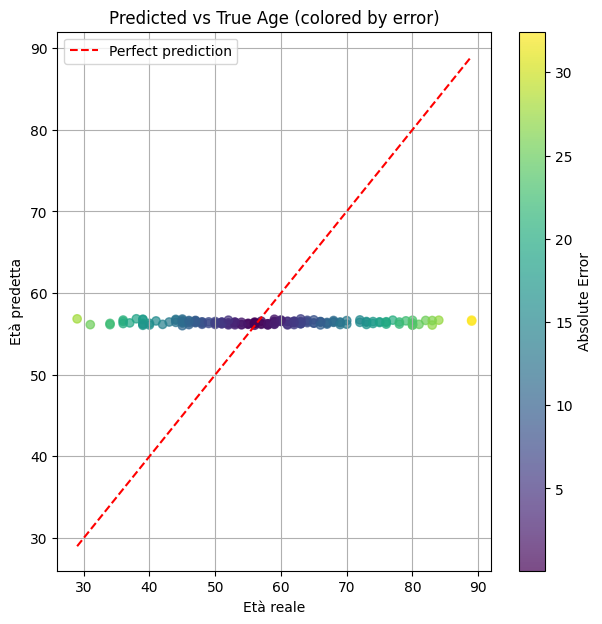

In [301]:
plot_real_vs_predicted(y_true, y_pred)

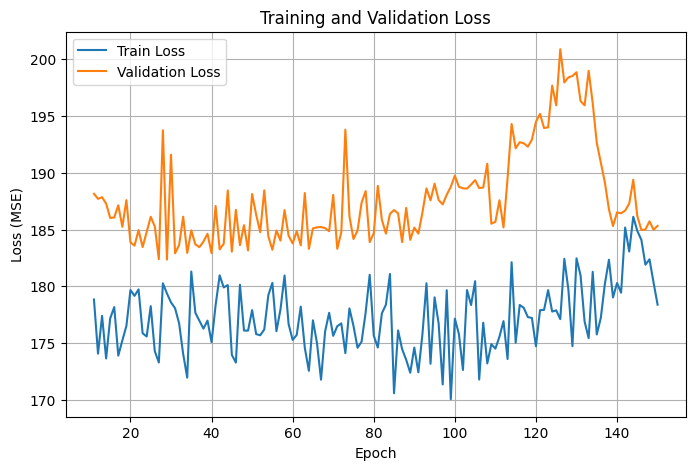

In [299]:
import matplotlib.pyplot as plt

df_history = pd.DataFrame(best_model.history)
plot_losses_from_gridSearch(df_history)